In [13]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
import matplotlib.pyplot as plt
import numpy as np

In [14]:
from matplotlib import rcParams, cm
from math import floor

In [15]:
%matplotlib inline
rcParams.update({'font.size': 14, 'text.usetex': True})

In [16]:
# make qutip available in the rest of the notebook
from qutip import *

We consider the dynamics of an atom-cavity system, whose Hamiltonian is described by Rabi Model:

$$
\hat{H} = \hbar \omega_c \hat{a}^\dagger \hat{a} + \frac{1}{2} \hbar\omega_a \hat{\sigma}_z + \hbar g \hat{\sigma}_x (\hat{a} + \hat{a}^\dagger)
$$

This Hamiltonian can be decomposed into three parts: 

(i) Non-interacting Hamiltonian: $\hat{H}_0 = \hbar\omega_c \hat{a}^\dagger \hat{a} + \frac{1}{2} \hbar\omega_a \hat{\sigma}_z$

(ii) Counter-rotating part: $\hat{H}_1 = \hbar g (\hat{a}^\dagger\hat{\sigma}_+ + \hat{a} \hat{\sigma}_- )$

(iii) Co-rotating part: $\hat{H}_2 = \hbar g (\hat{a}^\dagger\hat{\sigma}_- + \hat{a} \hat{\sigma}_+ )$

In [17]:
N = 10         # number of cavity fock states

excited, ground = basis(2,0), basis(2,1)

vacuum = basis(N,0)
coh1 = coherent(N, 1)

# intial state
psi0 = tensor(basis(N,0), excited)    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), sigmam())
sp = tensor(qeye(N), sigmap())
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

In [18]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.1 * 2 * np.pi  # coupling strength

# Rabi Model Hamiltonian decomposed into three parts:
H_list = [wc * a.dag() * a + 0.5 * wa * sz,
          g * (a.dag() * sm.dag() + a * sm),
          g * (a * sm.dag() + a.dag() * sm)]

T = 10

In [21]:
def result_wo(H_list, rho0, c_ops, e_ops, T1, T2): # master eqn solver without approximation
    return mesolve(sum(H_list), rho0, np.linspace(T1, T2, 1000), c_ops, e_ops)

def results(H_list, rho0, c_ops, e_ops, T1, T2, m_list):
    # master eqn solver under approximation based on Trotter formula
    results = []
    
    T = T2 - T1
    if T < 0:
        return ValueError("T2 should be larger than T1")

    n = len(H_list)
    
    for m in m_list:
        def pulse(n_):
            return lambda t, args: 1.0 * (floor(m * (t - T1) / T) % n == n_)
        
        H_args = []
        for n_ in range(n):
            H_args.append([H_list[n_], pulse(n_)])
        results.append(mesolve(H_args, rho0, np.linspace(T1, T1 + n * T, 1000), c_ops, e_ops))
    return results

To simulate the time-evolution $\hat{U} = e^{-i\hat{H}t/\hbar}\quad(0<t<T)$, we make use of the Trotter formula,

This can be thought of as applying $3m$ pulses of equal duration $T/m$, where the Hamiltonian varies as
$$
\hat{H}(t) =
\begin{cases}
\hat{H}_0 & \textrm{if}\ \ \ 0\le \mathrm{mod}\left(\frac{mt}{T}, 3\right)< 1,\\
\hat{H}_1 & \textrm{if}\ \ \ 1\le \mathrm{mod}\left(\frac{mt}{T}, 3\right)< 2,\\
\hat{H}_2 & \textrm{if}\ \ \ 2\le \mathrm{mod}\left(\frac{mt}{T}, 3\right)< 3.
\end{cases}
$$

Simulation with 
$$\hat{\mathscr{U}}_m = \left(e^{-i\hat{H}_2 T/m\hbar} e^{-i\hat{H}_1 T/m\hbar}e^{-i\hat{H}_0 T/m\hbar} \right)^m$$

In [22]:
m_list = [1, 2, 3, 5, 10, 20, 30, 50]
result0 = result_wo(H_list, psi0, [], [sx, sy, sz, a.dag() * a, sm.dag() * sm], 0, 10)
result = results(H_list, psi0, [], [sx, sy, sz, a.dag() * a, sm.dag() * sm], 0, 10, m_list)

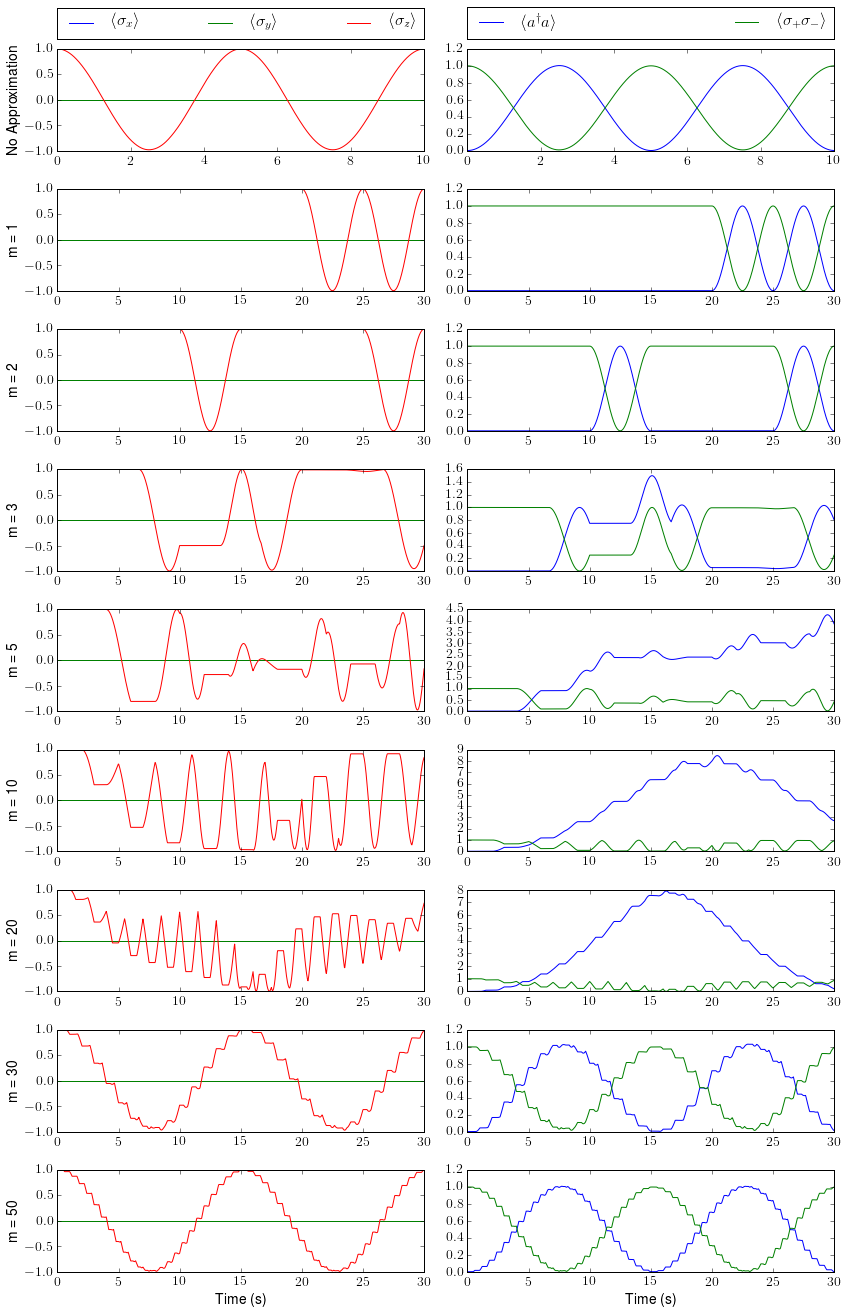

In [12]:
fig, axes = plt.subplots(len(m_list)+1, 2, figsize = (12,2*(len(m_list)+1)))
axes[0, 0].plot(result0.times, result0.expect[0], label=r'$\langle \sigma_x \rangle$')
axes[0, 0].plot(result0.times, result0.expect[1], label=r'$\langle \sigma_y \rangle$')
axes[0, 0].plot(result0.times, result0.expect[2], label=r'$\langle \sigma_z \rangle$')
axes[0, 0].legend(bbox_to_anchor=(0., 1.1, 1., .08), loc=3, ncol=3, mode="expand", borderaxespad=0.)
axes[0, 0].set_ylabel('No Approximation')

axes[0, 1].plot(result0.times, result0.expect[3], label=r'$\langle a^\dagger a \rangle$')
axes[0, 1].plot(result0.times, result0.expect[4], label=r'$\langle \sigma_+ \sigma_- \rangle$')
axes[0, 1].legend(bbox_to_anchor=(0., 1.1, 1., .08), loc=3, ncol=2, mode="expand", borderaxespad=0.)

for m in range(len(m_list)):
    axes[m+1, 0].plot(result[m].times, result[m].expect[0], label=r'$\langle \sigma_x \rangle$')
    axes[m+1, 0].plot(result[m].times, result[m].expect[1], label=r'$\langle \sigma_y \rangle$')
    axes[m+1, 0].plot(result[m].times, result[m].expect[2], label=r'$\langle \sigma_z \rangle$')

    axes[m+1, 0].set_ylabel('m = %d' % m_list[m])

    axes[m+1, 1].plot(result[m].times, result[m].expect[3], label=r'$\langle a^\dagger a \rangle$')
    axes[m+1, 1].plot(result[m].times, result[m].expect[4], label=r'$\langle \sigma_+ \sigma_- \rangle$')

axes[-1, 0].set_xlabel('Time (s)'); axes[-1, 1].set_xlabel('Time (s)')
fig.tight_layout();

Simulation with 
$$\hat{\mathscr{U}}_m = \left(e^{-iH_1 T/m\hbar} e^{-iH_2 T/m\hbar}e^{-iH_0 T/m\hbar} \right)^m$$

In [11]:
H_list1 = [H_list[0], H_list[2], H_list[1]]

In [9]:
m_list1 = [1, 2, 3, 5, 10, 11, 12, 13, 14, 15, 16]
result0 = result_wo(H_list1, psi0, [], [sx, sy, sz, a.dag() * a, sm.dag() * sm], 0, 8)
result = results(H_list1, psi0, [], [sx, sy, sz, a.dag() * a, sm.dag() * sm], 0, 8, m_list1)

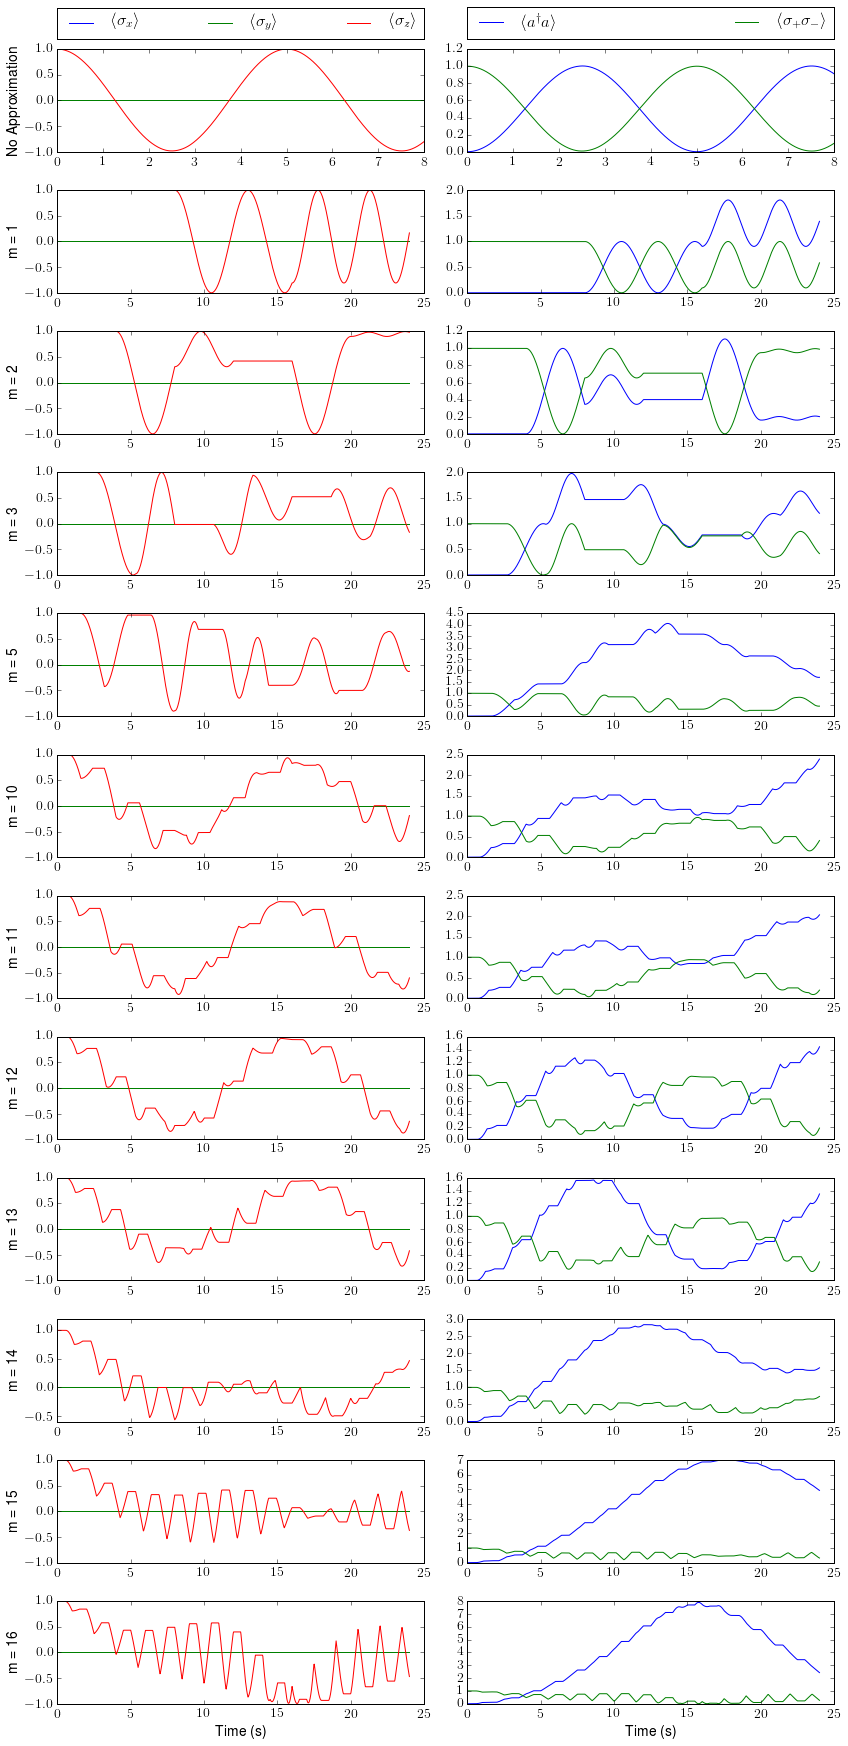

In [13]:
fig, axes = plt.subplots(len(m_list1)+1, 2, figsize = (12,2*(len(m_list1)+1)))
axes[0, 0].plot(result0.times, result0.expect[0], label=r'$\langle \sigma_x \rangle$')
axes[0, 0].plot(result0.times, result0.expect[1], label=r'$\langle \sigma_y \rangle$')
axes[0, 0].plot(result0.times, result0.expect[2], label=r'$\langle \sigma_z \rangle$')
axes[0, 0].legend(bbox_to_anchor=(0., 1.1, 1., .08), loc=3, ncol=3, mode="expand", borderaxespad=0.)
axes[0, 0].set_ylabel('No Approximation')

axes[0, 1].plot(result0.times, result0.expect[3], label=r'$\langle a^\dagger a \rangle$')
axes[0, 1].plot(result0.times, result0.expect[4], label=r'$\langle \sigma_+ \sigma_- \rangle$')
axes[0, 1].legend(bbox_to_anchor=(0., 1.1, 1., .08), loc=3, ncol=2, mode="expand", borderaxespad=0.)

for m in range(len(m_list1)):
    axes[m+1, 0].plot(result[m].times, result[m].expect[0], label=r'$\langle \sigma_x \rangle$')
    axes[m+1, 0].plot(result[m].times, result[m].expect[1], label=r'$\langle \sigma_y \rangle$')
    axes[m+1, 0].plot(result[m].times, result[m].expect[2], label=r'$\langle \sigma_z \rangle$')

    axes[m+1, 0].set_ylabel('m = %d' % m_list1[m])

    axes[m+1, 1].plot(result[m].times, result[m].expect[3], label=r'$\langle a^\dagger a \rangle$')
    axes[m+1, 1].plot(result[m].times, result[m].expect[4], label=r'$\langle \sigma_+ \sigma_- \rangle$')

axes[-1, 0].set_xlabel('Time (s)'); axes[-1, 1].set_xlabel('Time (s)')
fig.tight_layout();

### $T / m$ vs. $m$ Map for Fidelity

In [16]:
m_list = range(1, 30)
T_list = np.linspace(1e-5, 10, 100)

overlap = np.zeros((len(m_list), len(T_list)))

n = len(H_list)
dT = 5e-2

## This calculation takes about 12 hours
for idx1, m in enumerate(m_list):
    for idx2, T in enumerate(T_list):
        
        rho1 = mesolve(sum(H_list), psi0, np.arange(0, T, dT), [], []).states[-1]
        
        def pulse(n_):
            return lambda t, args: 1.0 * (floor(m * t / T) % n == n_)
        
        H_args = []
        for n_ in range(n):
            H_args.append([H_list[n_], pulse(n_)])
        rho2 = mesolve(H_args, psi0, np.arange(0, n * T, dT), [], []).states[-1]

        overlap[idx1, idx2] = fidelity(rho1, rho2)
    print('m = %d' % m, overlap[idx1, :])

m = 1 [ 1.          0.99999729  0.99995646  0.99986204  0.99976766  0.99973029
  0.99968176  0.99952223  0.99926949  0.99904756  0.99890515  0.99875526
  0.99851571  0.99822113  0.99793323  0.99765118  0.9973752   0.99721512
  0.99708865  0.99690396  0.99659694  0.99631588  0.99627449  0.99641018
  0.99641685  0.99617813  0.99598132  0.99613476  0.99651764  0.99672942
  0.99665229  0.99660576  0.99688525  0.99717891  0.99752456  0.99763936
  0.99775989  0.99805881  0.99844005  0.99872773  0.99889987  0.99905597
  0.99923946  0.99941994  0.99957437  0.99971032  0.99981928  0.99988695
  0.99992397  0.99995599  0.99997106  0.99995469  0.99994381  0.99992127
  0.99981751  0.99963053  0.99947674  0.99943306  0.99938078  0.99914952
  0.99877498  0.9984871   0.9983881   0.99829287  0.99799396  0.99755964
  0.99714525  0.99703331  0.99694947  0.99675912  0.99652491  0.99635083
  0.99624099  0.99617683  0.99618662  0.9962728   0.99632538  0.99627418
  0.99626899  0.99649296  0.99687196  0.99711

In [17]:
X,Y = np.meshgrid(m_list, T_list)
Z = overlap

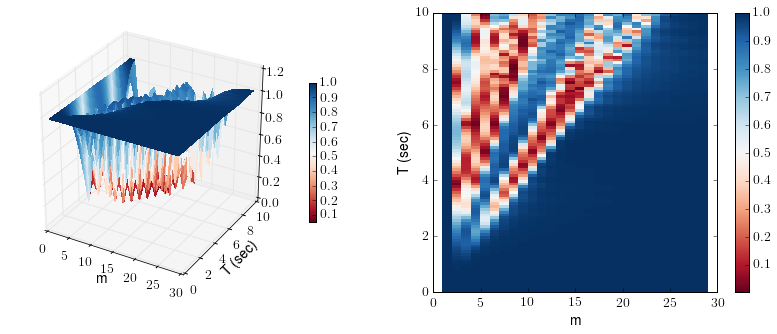

In [18]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
p = ax0.plot_surface(X, Y, Z.T, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.5)
ax0.set_xlabel('m')
ax0.set_ylabel('T (sec)')

ax1 = fig.add_subplot(1, 2, 2)
p = ax1.pcolor(X, Y, Z.T, cmap=cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
cb = fig.colorbar(p, ax=ax1)
ax1.set_xlabel('m')
ax1.set_ylabel('T (sec)');

In [ ]:
##### m_list = range(1, 100)
T_list = np.linspace(1e-5, 51, 100)

overlap1 = np.zeros((len(m_list), len(T_list)))

n = len(H_list)
dT = 5e-2

for idx1, m in enumerate(m_list):
    for idx2, T in enumerate(T_list):
        
        rho1 = mesolve(sum(H_list), psi0, np.arange(0, T, dT), [], []).states[-1]
        
        def pulse(n_):
            return lambda t, args: 1.0 * (floor(m * t / T) % n == n_)
        
        H_args = []
        for n_ in range(n):
            H_args.append([H_list[n_], pulse(n_)])
        rho2 = mesolve(H_args, psi0, np.arange(0, n * T, dT), [], []).states[-1]

        overlap[idx1, idx2] = fidelity(rho1, rho2)
    print('m = %d' % m, overlap[idx1, :])

In [ ]:
X,Y = np.meshgrid(m_list, T_list)
Z = overlap1

In [ ]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
p = ax0.plot_surface(X, Y, Z.T, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.5)
ax0.set_xlabel('m')
ax0.set_ylabel('T (sec)')

ax1 = fig.add_subplot(1, 2, 2)
p = ax1.pcolor(X, Y, Z.T, cmap=cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
cb = fig.v    rbar(p, ax=ax1)
ax1.set_xlabel('m')
ax1.set_ylabel('T (sec)');

In [ ]:
m_list = range(1, 30)
T_m_list = np.linspace(0, 30, 100)

overlap = np.zeros((len(m_list), len(T_list)))

n = len(H_list)
dT = 5e-2

for idx1, m in enumerate(m_list):
    for idx2, T_m in enumerate(T_m_list):
        T = T_m * m
        
        rho1 = mesolve(sum(H_list), psi0, np.arange(0, T, dT), [], []).states[-1]
        
        def pulse(n_):
            return lambda t, args: 1.0 * (floor(m * t / T) % n == n_)
        
        H_args = []
        for n_ in range(n):
            H_args.append([H_list[n_], pulse(n_)])
        rho2 = mesolve(H_args, psi0, np.arange(0, n * T, dT), [], []).states[-1]

        overlap[idx1, idx2] = fidelity(rho1, rho2)
    print('m = %d' % m, overlap[idx1, :])

In [ ]:
X,Y = np.meshgrid(m_list, T_m_list)
Z = overlap2

In [ ]:
fig = plt.figure(figsize=(14,5))
# surface_plot with color grading and color bar
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
p = ax0.plot_surface(X, Y, Z.T, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.5)
ax0.set_xlabel('m')
ax0.set_ylabel('T/m (sec)')

ax1 = fig.add_subplot(1, 2, 2)
p = ax1.pcolor(X, Y, Z.T, cmap=cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
cb = fig.colorbar(p, ax=ax1)
ax1.set_xlabel('m')
ax1.set_ylabel('T/m (sec)');

In [20]:
fig, ax = 